## Display the xml element tree

In [19]:
from pptlayout.extractors.run_extractors import run_extractors
from json import dumps
# Replace with your actual PPTX file path
pptx_path = "/data/tianyuhu/PPTLayout/data/pptx/ZK7FNUZ33GBBCG7CFVYS56TQCTD72CJR.pptx"

# Run extractors
info = run_extractors(pptx_path, "inch")
print(dumps(info, indent=4))

{
    "slide_width": 10.0,
    "slide_height": 7.5,
    "slides": [
        {
            "slide_id": 256,
            "slide_name": "",
            "shapes": [
                {
                    "name": "PlaceHolder 1",
                    "shape_id": 22,
                    "shape_type": "PLACEHOLDER",
                    "measurement_unit": "inch",
                    "height": 2.4374015748031495,
                    "width": 8.5,
                    "left": 0.75,
                    "top": 1.4996062992125985,
                    "text": "Design for a 2 MW graphite target\u000b\u000bfor a neutrino beam",
                    "placeholder_type": "TITLE"
                },
                {
                    "name": "PlaceHolder 2",
                    "shape_id": 23,
                    "shape_type": "PLACEHOLDER",
                    "measurement_unit": "inch",
                    "height": 1.9165354330708662,
                    "width": 8.916929133858268,
                    "

In [ ]:
from pptlayout.llm.call_ollama import generate_slide_layout_suggestions
from pptlayout.llm.prompts import build_slide_layout_suggestion_prompts
from tqdm import tqdm
import os
# Call OLLAMA
output_dir = os.path.join(os.curdir, "test_output")
suggestions_list = []
for slide_info in tqdm(info["slides"]):
    slide_id = slide_info["slide_id"]
    slide_output_dir = os.path.join(output_dir, f"{slide_id}")
    if os.path.exists(os.path.join(slide_output_dir, "suggestions.txt")):
        with open(os.path.join(slide_output_dir, "suggestions.txt"), "r") as f:
            suggestions = f.read()
        suggestions_list.append(suggestions)
        continue
    prompt = build_slide_layout_suggestion_prompts(
        json_input=slide_info, 
        slide_width=info["slide_width"],
        slide_height=info["slide_height"]
        )
    suggestions = generate_slide_layout_suggestions(
        model_name="llama3.1:70b",
        prompt=prompt,
        temperature=0.5,
        )
    suggestions_list.append(suggestions)
    # save
    os.makedirs(slide_output_dir, exist_ok=True)
    with open(os.path.join(slide_output_dir, "suggestions.txt"), "w") as f:
        f.write(suggestions)

In [ ]:
from pptlayout.llm.parser import extract_json
json_list = []
for suggestions in suggestions_list:
    json_data = extract_json(suggestions)
    json_list.append(json_data)

In [ ]:
from json import dumps

# print(dumps(json_list[12], indent=4))
for json in json_list:
    print(json)

In [ ]:
from pptlayout.visualizers.layout_visualizer import generate_comparison_grid

slides = info["slides"]
# Generate comparison grid
comparison_grid = generate_comparison_grid(
    slides,
    json_list,
    slide_width=info["slide_width"],
    slide_height=info["slide_height"]
    )

## test

In [7]:
from pptlayout.extractors.run_extractors import run_extractors
from json import dumps
# Replace with your actual PPTX file path
pptx_path = "/data/tianyuhu/PPTLayout/data/pptx/ZK7FNUZ33GBBCG7CFVYS56TQCTD72CJR.pptx"

# Run extractors
info = run_extractors(pptx_path, "pt")
# print(dumps(info, indent=4))


from pptlayout.llm.call_ollama import call_ollama
from pptlayout.llm.prompts import build_slide_layout_suggestion_prompts
test_image = "/data/tianyuhu/PPTLayout/notebooks/test_input/image_grid.png"
prompt = "What is the estimate length of the title text box? For your information, the slide width is 540 and the slide height is 720."

# prompt = build_slide_layout_suggestion_prompts(
#     json_input=info["slides"][4],
#     slide_width=info["slide_width"],
#     slide_height=info["slide_height"],
#     )
response = call_ollama(
    model_name="llama3.2-vision:11b",
    prompt=prompt,
    images=[test_image],
    # json=True,
    ) 
print(response)

The image shows a PowerPoint slide with a title box containing the text "A History of the Universe". The slide width is 540 pixels and the slide height is 720 pixels.

To estimate the length of the title text box, we need to determine its width in relation to the slide's width. Since the title text box spans almost the entire width of the slide, we can assume that it takes up approximately half or more of the slide's width.

Given that the slide's width is 540 pixels, a reasonable estimate for the length of the title text box would be around 270-300 pixels. This range allows for some flexibility in case the actual text is longer or shorter than expected.

Therefore, based on the provided information and visual analysis of the image, an estimated length of the title text box could be:

*Answer*: 270-300


In [6]:
from pptlayout.llm.parser import extract_json
from json import dumps
# Extract JSON data
json_data = extract_json(response)
print(dumps(json_data, indent=4))

JSON markers not found in the text.
{
    "slide_id": 260,
    "slide_name": "",
    "shapes": [
        {
            "name": "PlaceHolder 1",
            "shape_id": 38,
            "shape_type": "PLACEHOLDER",
            "measurement_unit": "pt",
            "height": 42.00944881889764,
            "width": 510.0094488188976,
            "left": 119.99055118110236,
            "top": 11.990551181102362,
            "text": "NuMI baffle as prototype of target",
            "placeholder_type": "TITLE"
        },
        {
            "name": "",
            "shape_id": 39,
            "shape_type": "AUTO_SHAPE",
            "measurement_unit": "pt",
            "height": 60.00944881889764,
            "width": 180.0,
            "left": 47.99055118110236,
            "top": 432.0,
            "text": ""
        },
        {
            "name": "",
            "shape_id": 40,
            "shape_type": "AUTO_SHAPE",
            "measurement_unit": "pt",
            "height": 18.0,
    

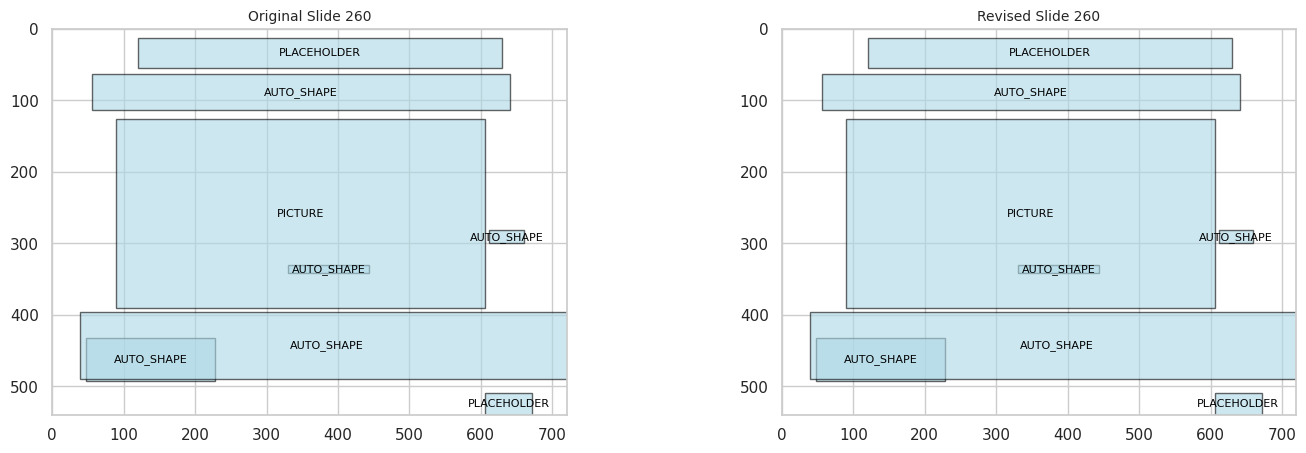

In [7]:
from pptlayout.visualizers.layout_visualizer import generate_comparison_grid

generate_comparison_grid(
    [info["slides"][4]],
    [json_data],
    slide_width=info["slide_width"],
    slide_height=info["slide_height"]
    )
    

(1762, 2354, 3)


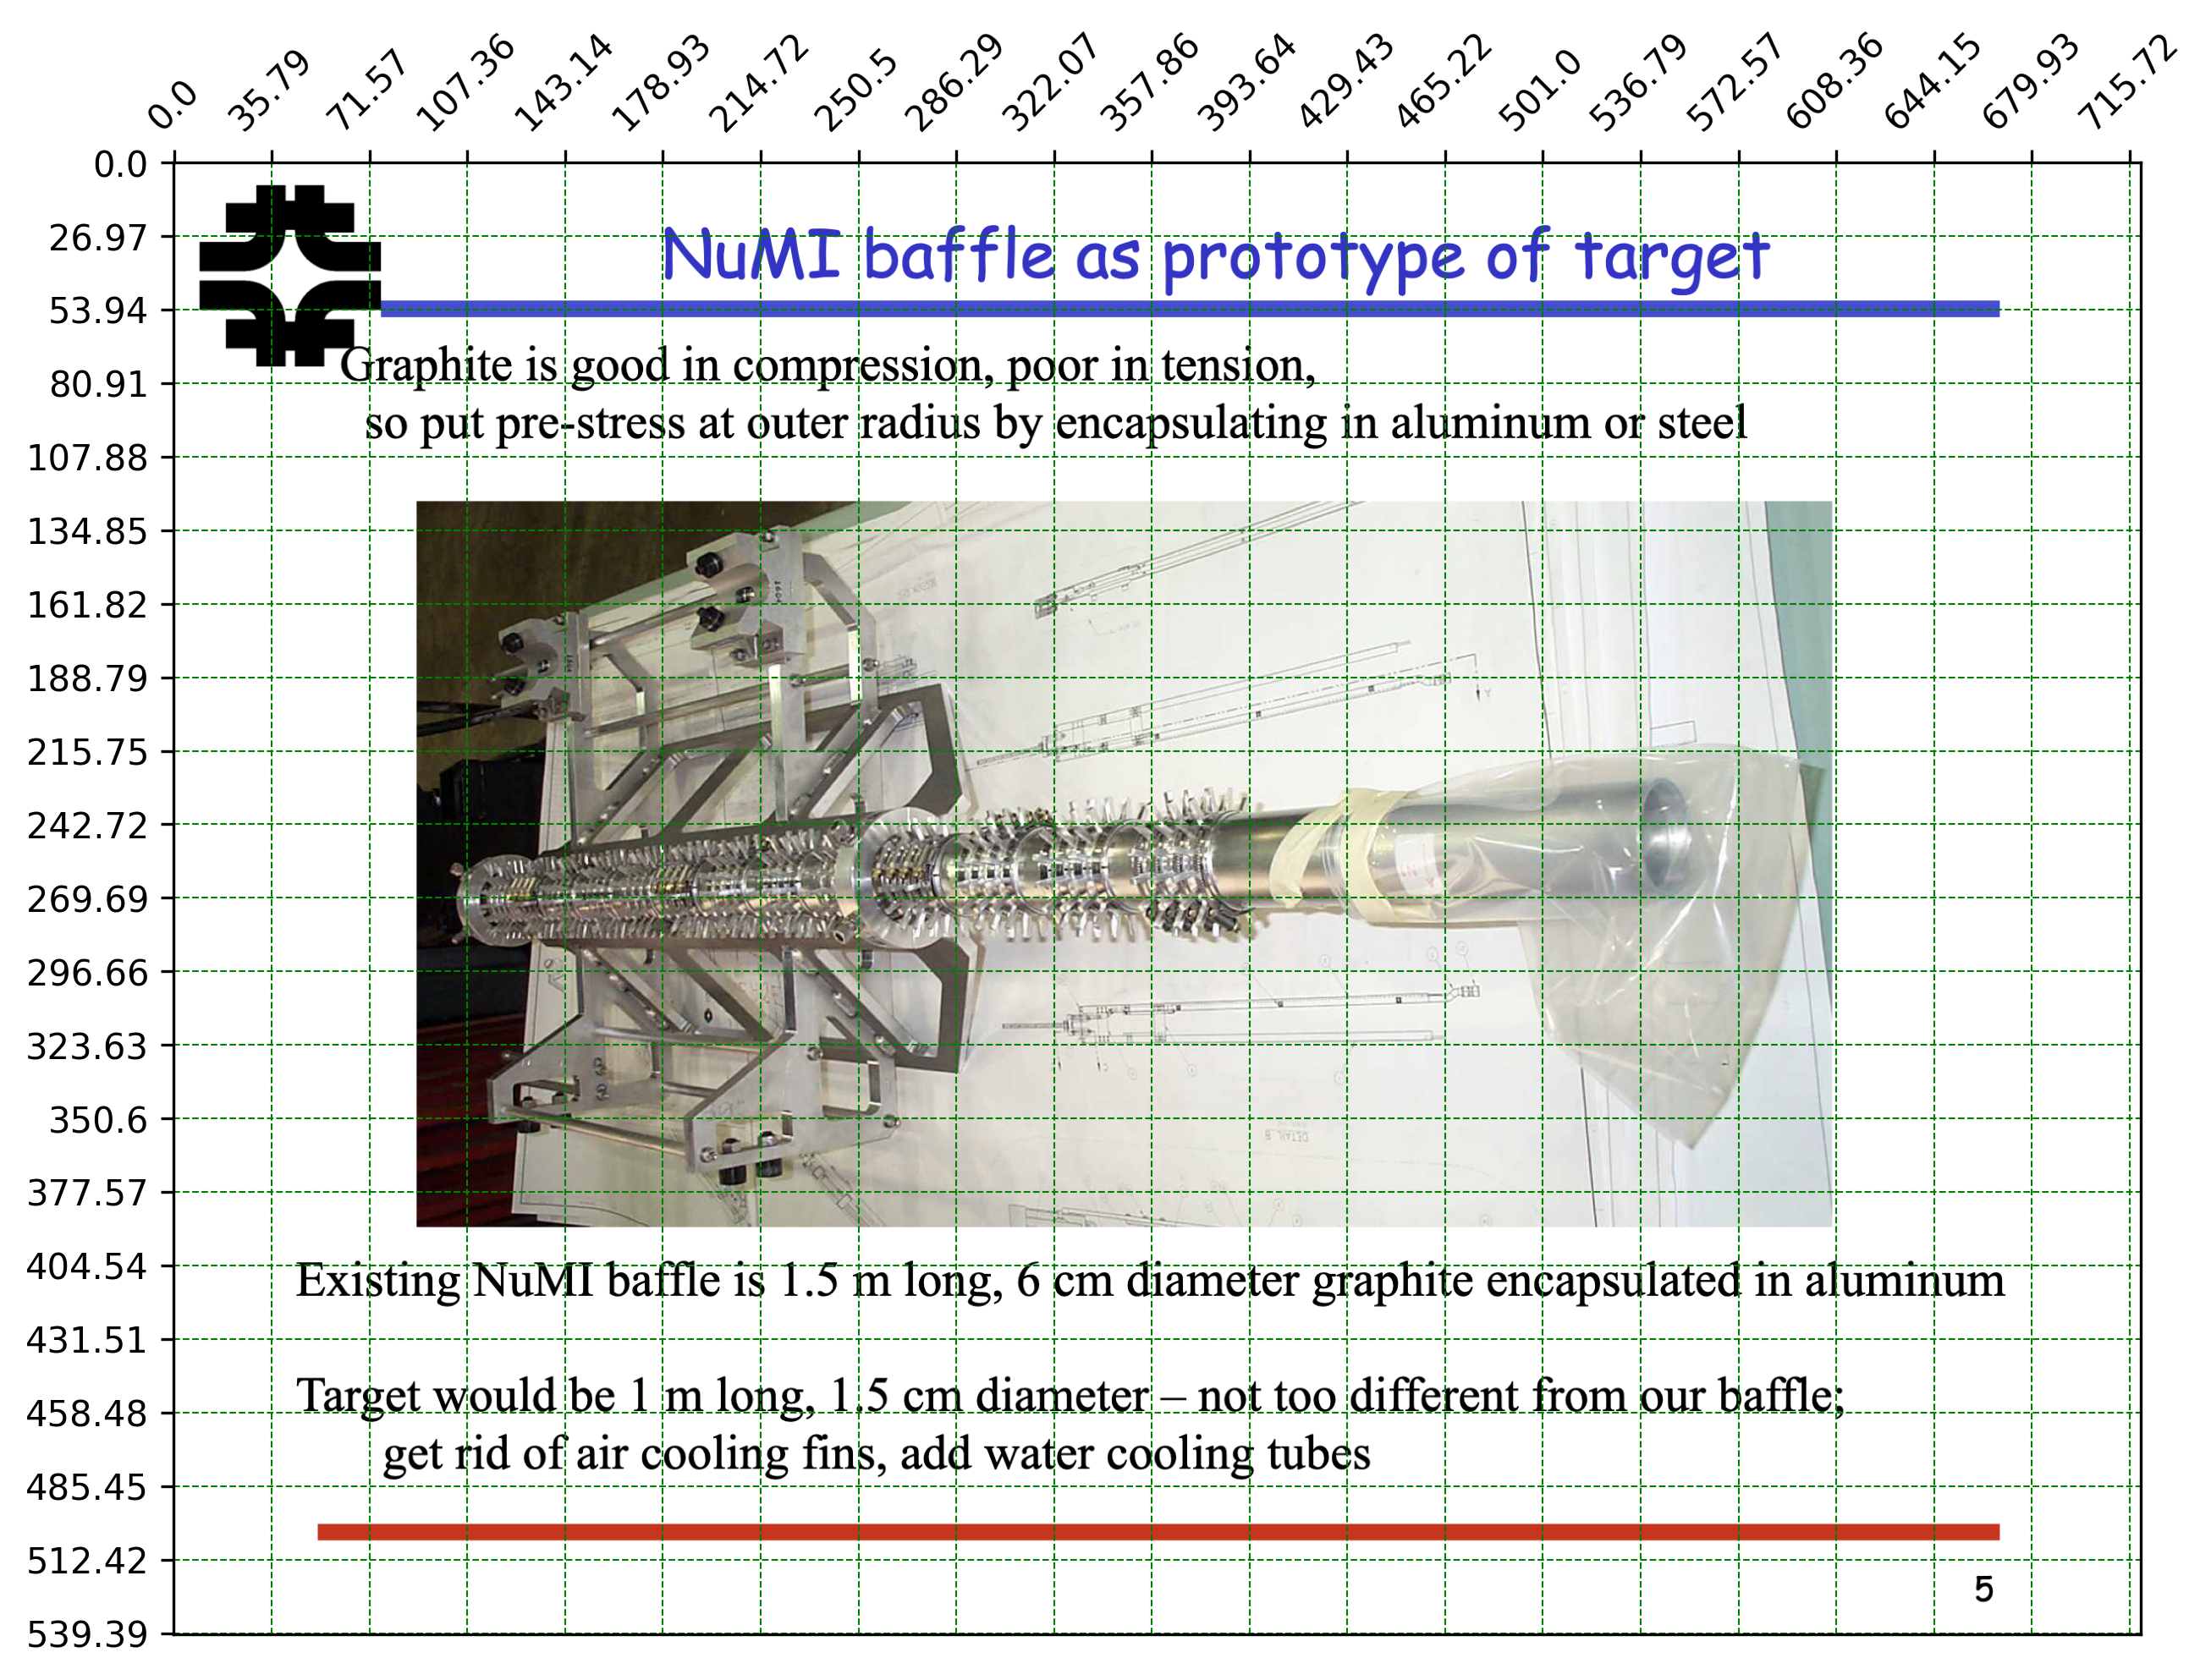

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import cv2

# Load the image using OpenCV
image_path = '/data/tianyuhu/PPTLayout/notebooks/test_input/image.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
print(image.shape)

image_width = image.shape[1]
image_height = image.shape[0]

slide_width = 720
slide_height = 540
scale_x = slide_width / image_width
scale_y = slide_height / image_height

# Create a figure and display the image
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.imshow(image)

# Overlay grids
ax.grid(color='green', linestyle='--', linewidth=0.5)  # Customize grid color and style
interval_num = 20
x_tick_interval = image_width // interval_num
y_tick_interval = image_height // interval_num

# Customize axis ticks and labels
# Set the tick positions based on the image size
ax.set_xticks(np.arange(0, image_width, x_tick_interval))
ax.set_yticks(np.arange(0, image_height, y_tick_interval))

# Set tick labels based on the slide size
ax.set_xticklabels(np.round(np.arange(0, slide_width, x_tick_interval * scale_x), 2))
ax.set_yticklabels(np.round(np.arange(0, slide_height, y_tick_interval * scale_y), 2))

ax.xaxis.tick_top()

# Set the ticks on the horizontal axis to 45 degrees
plt.xticks(rotation=45)

# Show axes
ax.set_axis_on()
plt.savefig('/data/tianyuhu/PPTLayout/notebooks/test_input/image_grid.png')

# Display the image with the overlay
plt.show()
